In [1]:
import pyntcloud
import pickle
import tensorflow as tf
import numpy as np
import importlib
from train import provider
from train import box_util

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
importlib.reload(box_util)
importlib.reload(provider)

<module 'train.provider' from '/datasets/home/90/490/scgullap/ece_285_proj/frustum-pointnets/train/provider.py'>

In [3]:
NUM_POINT=2048
TRAIN_DATASET = provider.FrustumDataset(npoints=NUM_POINT, split='train',\
                            rotate_to_center=True, random_flip=False, random_shift=False, one_hot=True)

In [4]:
VAL_DATASET = provider.FrustumDataset(npoints=NUM_POINT, split='val',\
                            rotate_to_center=True, random_flip=False, random_shift=False, one_hot=True)

In [5]:
point_set,labels,c,d,e,f,g,h,i = TRAIN_DATASET[0]

In [6]:
len(TRAIN_DATASET)

73480

In [7]:
point_set.shape

(2048, 4)

In [8]:
TRAIN_DATASET.get_center_view_box3d(1)

array([[ 0.63603565,  1.47      ,  8.95986384],
       [ 0.7288103 ,  1.47      ,  8.48891494],
       [-0.44856195,  1.47      ,  8.25697831],
       [-0.5413366 ,  1.47      ,  8.72792721],
       [ 0.63603565, -0.42      ,  8.95986384],
       [ 0.7288103 , -0.42      ,  8.48891494],
       [-0.44856195, -0.42      ,  8.25697831],
       [-0.5413366 , -0.42      ,  8.72792721]])

In [9]:
def indices(window_len, stride_len, point_set, labels, corners_gt):
    IOU = []
    start = []
    end = []
    IOU_1 = []
    IOU_2 = []
    corner = []
    j = np.min(point_set,0)[2]
    i = j+window_len
    idtuple=set()
    while i<=np.max(point_set,0)[2]:
            max_ind = np.searchsorted(point_set[:,2], i)
            min_ind = np.searchsorted(point_set[:,2], j)
            if (min_ind,max_ind) not in idtuple and max_ind-min_ind>5:
                #print('fgbd')
                idtuple.add((min_ind,max_ind))
                labels_window = np.zeros_like(point_set[:,0])
                labels_window[min_ind:max_ind] = 1.0
                union = np.sum(np.logical_or(labels, labels_window))
                inter = np.sum(np.logical_and(labels, labels_window))
                if (inter*1.0/union) < 0.3 or (inter*1.0/union) >0.7 :
                    end.append(max_ind)
                    start.append(min_ind)
                    IOU.append(inter*1.0/union)
            j = j+stride_len
            i = j+window_len
    IOU = np.array(IOU)>=0.7
    return np.array(start),np.array(end), np.array(IOU)



In [10]:
# points in each window:2048
# number of windows
#

def get_list(start_idx,end_idx,num_points=1024,ensure_all=True):
    """
    param:
    start_idx  : list of indexes of the starting point in each window
    end_idx    : list of indees of ending point in each window
    NOTES: we used two lists because we ran into issues with tensorflow when we used tuples,
           this is a quick hack to avoid that
    num_points : number of points to be sampled from i.e number of points in each window
    ensure_all : in the case that there are fewwer than required points ensures all points are picked atleast once if selected as True
    
    
    returns:
    out:  an array of size 
          
          num_windowsxnum_pointsx1
          
          this will be used inside tensorflow to divide into windows 
          after we pass the points trough pointnet
    """
    
    out= []
    for i in range(np.shape(start_idx)[0]):
        
        if end_idx[i]-start_idx[i]+1<=num_points:
            indexes=np.arange(start_idx[i],end_idx[i])
            indexes2=np.random.choice(indexes, num_points-np.shape(indexes)[0],replace=True)
            indexes=np.concatenate((indexes,indexes2))
        else:
            indexes=np.random.choice(np.arange(start_idx[i],end_idx[i]),num_points,replace=False)
        out.append(np.reshape(indexes,(-1,1)))
    
    return np.array(out)


In [11]:
import tf_util #for conv2d
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER, NUM_OBJECT_POINT
from model_util import point_cloud_masking, get_center_regression_net
from model_util import placeholder_inputs, parse_output_to_tensors, get_loss
from model_util import huber_loss

In [12]:
# https://github.com/ailias/Focal-Loss-implement-on-Tensorflow/blob/master/focal_loss.py


from tensorflow.python.ops import array_ops

def focal_loss(sigmoid_p, target_tensor, weights=None, alpha=0.99, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log
            (1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    #sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(target_tensor, dtype=target_tensor.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1.0 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [13]:
# def classification_net(point_cloud, label_out_5, label_out_1, label_out_2, label_out_3, label_out_4, idx5, idx1, idx2, idx3, idx4, 
#                             is_training=True, bn_decay=True):
def classification_net(point_cloud, label_out_5,  idx5, 
                            is_training=True, bn_decay=True):
    '''
    3D PointNet network.
    param:
    
    point_cloud: TF tensor in shape (1,N,4)
                 frustum point clouds with XYZ and intensity in point channels
                 XYZs are in frustum coordinate
    label_out: TF tensor in shape (1,1)
            length-1 vector indicating the classification as car or background
    
    ??????????????????????????????????????????????????????????????????????????????????????
    
    is_training: TF boolean scalar
    bn_decay: TF float scalar
    end_points: dict                 SHOULD CHANGE THIS
    Output:                                         
    logits: TF tensor in shape (B,N,2), scores for bkg/clutter and object
    end_points: dict
    ??????????????????????????????????????????????????????????????????????????????????????
    '''
    
    batch_size = point_cloud.get_shape()[0].value #1 in our case
    num_point = point_cloud.get_shape()[1].value  #N in our case
  
    net = tf.expand_dims(point_cloud, 2)
    #print(net.get_shape())

    net = tf_util.conv2d(net, 64, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv1', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv2', bn_decay=bn_decay)
    point_feat = tf_util.conv2d(net, 64, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv3', bn_decay=bn_decay)
    net = tf_util.conv2d(point_feat, 128, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv4', bn_decay=bn_decay)
    features = tf_util.conv2d(net, 1024, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv5', bn_decay=bn_decay)
    
    features=tf.squeeze(features,axis=2)
    features=tf.squeeze(features,axis=0)   

    #features=tf.placeholder(tf.float32,[1,1024,4])

    def fn(x):
        return tf.gather_nd(features,x)
    
    windows_5 =tf.map_fn(fn,idx5,dtype=tf.float32)
#     windows_1 = tf.map_fn(fn,idx1,dtype=tf.float32)
#     windows_2 = tf.map_fn(fn,idx2,dtype=tf.float32)
#     windows_3 = tf.map_fn(fn,idx3,dtype=tf.float32)
#     windows_4 = tf.map_fn(fn,idx4,dtype=tf.float32)
    
    windows_5_1024 = tf.reduce_max(windows_5,axis=1)
#     windows_1_1024 = tf.reduce_max(windows_1,axis=1)
#     windows_2_1024 = tf.reduce_max(windows_2,axis=1)
#     windows_3_1024 = tf.reduce_max(windows_3,axis=1)
#     windows_4_1024 = tf.reduce_max(windows_4,axis=1)
    
    
    winex_5 =  tf.reshape(windows_5_1024,shape=[-1,1,1,1024])
#     winex_1 =  tf.reshape(windows_1_1024,shape=[-1,1,1,1024])
#     winex_2 =  tf.reshape(windows_2_1024,shape=[-1,1,1,1024])
#     winex_3 =  tf.reshape(windows_3_1024,shape=[-1,1,1,1024])
#     winex_4 =  tf.reshape(windows_4_1024,shape=[-1,1,1,1024])
   
    winex = tf.concat([winex_5], axis=0)
    label_out = tf.concat([label_out_5],axis=0)

    
    
#     winex = tf.concat([winex_5, winex_1, winex_2, winex_3, winex_4], axis=0)
#     label_out = tf.concat([label_out_5,label_out_1, label_out_2, label_out_3, label_out_4],axis=0)

    #classification head
    d1 = tf_util.conv2d(winex, 512, [1,1],
                             padding='VALID', stride=[1,1],
                             bn=True, is_training=is_training,
                             scope='dense1', bn_decay=bn_decay)
    d2 = tf_util.conv2d(d1, 256, [1,1],
                             padding='VALID', stride=[1,1],
                             bn=True, is_training=is_training,
                             scope='dense2', bn_decay=bn_decay)
    d2=tf.layers.dropout(d2,rate=0.5, training=is_training, name='drop1')
    
    logits = tf_util.conv2d(d2, 1, [1,1],
                             padding='VALID', stride=[1,1],
                             bn=True, is_training=is_training,
                             scope='out', bn_decay=bn_decay, activation_fn=None)
    
    logits = tf.squeeze(logits)
    logits=tf.reshape(tf.squeeze(logits),(1,-1))
    sig = tf.sigmoid(logits)

    #sig = tf.reshape(tf.squeeze(sig),(-1,1))
    y=tf.reshape(sig,[-1])
    
    max_ind = tf.argmax(y)
    
    tp = tf.equal(label_out[max_ind], 1)
    
    
    differentiable_round = tf.maximum(y-0.499,0)
    differentiable_round = differentiable_round * 10000
    y_pred = tf.minimum(differentiable_round, 1)
    #y_pred=tf.round(y)
    
    true_pos  = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(label_out,tf.bool),tf.cast(y_pred,tf.bool)),tf.float32))
    
    false_pos = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(tf.cast(label_out,tf.bool)),tf.cast(y_pred,tf.bool)),tf.float32))
    true_neg  = tf.reduce_sum(tf.cast(tf.logical_not(tf.logical_or(tf.cast(label_out, tf.bool),\
                                                                   tf.cast(y_pred, tf.bool))),tf.float32))
    false_neg = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not\
                                                     (tf.cast(y_pred,tf.bool)),tf.cast(label_out,tf.bool)),tf.float32))
    return sig,logits, label_out,true_pos,false_pos,true_neg,false_neg, tp, max_ind

In [14]:
# inputs=tf.placeholder(tf.float32,[None,2048,4])
# idx_5 =tf.placeholder(tf.int32,[None,num_points_5,1])
# is_training = tf.placeholder(tf.bool)
# label_out_5 = tf.placeholder(tf.int32, [None])

In [15]:
tf.reset_default_graph()
with tf.device('/device:GPU:0'):
    num_points_5 =512
#     num_points_1 = 512
#     num_points_2 = 512
#     num_points_3 = 512
#     num_points_4 = 512
    
    inputs=tf.placeholder(tf.float32,[None,2048,4])#put placeholder

    idx_5 =tf.placeholder(tf.int32,[None,num_points_5,1])

#     idx_1 = tf.placeholder(tf.int32,[None,num_points_1,1])
    
#     idx_2 = tf.placeholder(tf.int32,[None,num_points_2,1])

#     idx_3 = tf.placeholder(tf.int32,[None,num_points_3,1])
    
#     idx_4 = tf.placeholder(tf.int32,[None,num_points_4,1])

    is_training = tf.placeholder(tf.bool)
    

    label_out_5 = tf.placeholder(tf.int32, [None])
#     label_out_1 = tf.placeholder(tf.int32, [None])
#     label_out_2 = tf.placeholder(tf.int32, [None])
#     label_out_3 = tf.placeholder(tf.int32, [None])
#     label_out_4 = tf.placeholder(tf.int32, [None])

    sig,logits, label_out,tp,fp,tn,fn, tp_num, maxi = classification_net(inputs, label_out_5, \
                                         idx_5, is_training)
    
    
#     sig,logits, label_out,tp,fp,tn,fn = classification_net(inputs, label_out_5, label_out_1,label_out_2, label_out_3, label_out_4, \
#                                          idx_5, idx_1, idx_2, idx_3, idx_4, is_training)
    
    func_fl = focal_loss(tf.squeeze(sig),tf.squeeze(tf.cast(label_out, tf.float32)), gamma=0.75, alpha=0.25)
    print(label_out.get_shape())
#     loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
#     labels=tf.reshape(tf.cast(label_out,tf.float32),(-1,1)),
#     logits=tf.reshape(logits,(-1,1))))

    loss = tf.reduce_mean(func_fl)
#     tpr=tf.divide(tf.cast(tp,tf.float32),tf.add(tp,fp))
#     tnr=tf.divide(tf.cast(tn,tf.float32),tf.add(tn,fn))
#     loss=tf.reduce_sum(tf.constant(1.0)-tf.scalar_mul(0.5,tf.add(tpr,tnr)))
    
    
    optimizer = tf.train.AdamOptimizer(1e-5)
    #train_step=optimizer.minimize(loss)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)
    
    

(?,)


In [16]:
from tensorflow.python import debug
from pyntcloud import PyntCloud



In [22]:
# from random import shuffle
# val_trix=[cc for cc in range(VAL_DATASET.__len__())]
# shuffle(val_trix)
# np.save('./Windows/val_trix', val_trix, allow_pickle=True)

In [23]:
val_trix = np.load('./Windows/val_trix.npy')

In [24]:
val_trix=list(val_trix)

In [ ]:
import datetime
import logging
from random import shuffle
import pandas as pd
from tensorflow.python import debug as tf_debug
print(datetime.datetime.now().strftime("%a, %d %B %Y %I:%M:%S"))

IOU_list = []
point_cld = []
saver = tf.train.Saver()

prob = []
voxels_train=[]
center_label=[]
centroids=[]
centroids_unique=[]
corners=[]
lbh=[]
heading=[]
extras=[]
pedc=0
selwin=[]  
windows=[]
residuallbh=[]
for i in trix[:len(val_trix)]:
    #while pedc<6000:
        if TRAIN_DATASET.type_list[i]=='Pedestrian':
            pedc+=1
            print('processing example number: ',pedc)
            point_set,labels,a,b,c,d,e,f,cls = TRAIN_DATASET.__getitem__(i)
            point_set,labels,a,b,c,d,e,f,cls = TRAIN_DATASET.__getitem__(i)
            corners_gt = TRAIN_DATASET.get_center_view_box3d(i)
            #extras.append(TRAIN_DATASET.__getitem__(i))
            index = np.argsort(point_set[:,2])
            point_set= point_set[index]
            labels = labels[index]
            s5,e5,l = indices(1.0,0.1,point_set,labels, corners_gt)

            if s5.size:

                ind_5 = get_list(s5,e5, num_points=512)

                point_set = np.expand_dims(point_set, axis=0)
                wc=0
                for ci in range(len(l)):

                    if l[ci]:
                        while(wc<2):
                            wc+=1
                            #point_cld.append(point_set[0,ind_5[ci].reshape((-1)),:3])

                            seg = point_set[0,ind_5[ci].reshape((-1))]
                            #print(seg.shape)
                            point_cld.append(seg)
                            selwin.append(seg)
                            
#                             seg = pd.DataFrame(seg[:,:3])
#                             seg.columns = ['x','y','z']
#                             cloud = PyntCloud(seg)

#                             voxelgrid_id = cloud.add_structure("voxelgrid", size_x=0.05, size_y=0.05, size_z=0.05, regular_bounding_box=False)
#                             voxelgrid = cloud.structures[voxelgrid_id]
#                             voxels_train.append(voxelgrid)
                            
                            
                            #print(pedc, seg.drop_duplicates().shape[0])
                            #center_label.append(TRAIN_DATASET.get_center_view_box3d_center(i))
                            #centroids_unique.append(np.mean(np.unique(np.array(point_set[0,ind_list[:,0]]),axis=0), axis=0))
                            #centroids.append(np.mean(np.array(point_set[0,ind_list[:,0]]),axis=0))
                            #corners.append(corners_gt)
                            lbh.append(provider.class2size(d,e))
                            extras.append(TRAIN_DATASET.__getitem__(i))
                            #lbh.append(TRAIN_DATASET.__getitem__(i)[6])
                            #cloud.plot()





In [30]:
import datetime
import logging
from random import shuffle
import pandas as pd
#logging.basicConfig(filename='run_1.log',level=logging.DEBUG)
from tensorflow.python import debug as tf_debug
print(datetime.datetime.now().strftime("%a, %d %B %Y %I:%M:%S"))

saver = tf.train.Saver()



val_selwin=[]
val_extras=[]


with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    #sess=tf_debug.LocalCLIDebugWrapperSession(sess)
    sess.run(tf.global_variables_initializer())
    variables_names = [v.name for v in tf.trainable_variables()]
    values = sess.run(variables_names)
    #for k, v in zip(variables_names, values):
        #print("Variable: ", k)
        #print("Shape: ", v.shape)
    # uncomment this when we want to load the checkpoint model
    saver.restore(sess, "./checkpoints/model_new_labels_pointwiseIOU_5_10000.ckpt")
    for j in range(6,7):   
       
        pedc=0
        
        for i in val_trix:
        #todo reformat code to have lists instead of many variable
            if VAL_DATASET.type_list[i]=='Pedestrian':
                pedc+=1
                if pedc%500==0:
                    total_tp=0
                    total_fp=0
                    total_tn=0
                    total_fn=0
                    total_tpnums = 0
                    total_fpnums = 0
                    total_fnnums = 0
                point_set,labels,a,b,c,d,e,f,cls = VAL_DATASET.__getitem__(i)
                #print(point_set.shape)
                
                index = np.argsort(point_set[:,2])
                #raw_input()

                point_set= point_set[index]
                #print(point_set[:25])
                labels = labels[index]

                
                #print(point_set.shape)

                s5,e5,l = indices(1.0,0.1,point_set,labels, corners_gt)
                
                
                

                if s5.size :#and s2.size and s3.size and s4.size and s1.size:

                    ind_5 = get_list(s5,e5, num_points=512)
                    #print(ind_5.shape)
                   
 

                    point_set = np.expand_dims(point_set, axis=0)
                        
                    x,tpos,fpos,tneg,fneg, tpnums, maxind =sess.run([ loss,tp,fp,tn,fn, tp_num, maxi],feed_dict={idx_5:ind_5,\
                                                               label_out_5: l.astype(np.int32),\
                                                               inputs:point_set, is_training: True})
                    
                    #print(point_set.shape)
                    ind_list = ind_5[maxind]
                    #print(np.max(ind_list)-np.min(ind_list))
                    #print(ind_list[0])
                    #print(ind_list.shape)
                    seg = point_set[0,ind_list[:,0]]
                    print('processing example ',pedc)
                    val_selwin.append(seg[:,:3])
                    val_extras.append(VAL_DATASET.__getitem__(i))
                    
                    
                   

Mon, 11 June 2018 02:45:15
INFO:tensorflow:Restoring parameters from ./checkpoints/model_new_labels_pointwiseIOU_5_10000.ckpt
processing example  1
processing example  2
processing example  3
processing example  4
processing example  5
processing example  6
processing example  7
processing example  8
processing example  9
processing example  10
processing example  11
processing example  12
processing example  13
processing example  14
processing example  15
processing example  16
processing example  17
processing example  18
processing example  19
processing example  20
processing example  21
processing example  22
processing example  23
processing example  24
processing example  25
processing example  26
processing example  27
processing example  28
processing example  29
processing example  30
processing example  31
processing example  32
processing example  33
processing example  34
processing example  35
processing example  36
processing example  37
processing example  38
processin

processing example  345
processing example  346
processing example  347
processing example  348
processing example  349
processing example  350
processing example  351
processing example  352
processing example  353
processing example  354
processing example  355
processing example  356
processing example  357
processing example  358
processing example  359
processing example  360
processing example  361
processing example  362
processing example  363
processing example  364
processing example  365
processing example  366
processing example  367
processing example  368
processing example  369
processing example  370
processing example  371
processing example  372
processing example  373
processing example  374
processing example  375
processing example  376
processing example  377
processing example  378
processing example  379
processing example  380
processing example  381
processing example  382
processing example  383
processing example  384
processing example  385
processing examp

processing example  688
processing example  689
processing example  690
processing example  691
processing example  692
processing example  693
processing example  694
processing example  695
processing example  696
processing example  697
processing example  698
processing example  699
processing example  700
processing example  701
processing example  702
processing example  703
processing example  704
processing example  705
processing example  706
processing example  707
processing example  708
processing example  709
processing example  710
processing example  711
processing example  712
processing example  713
processing example  714
processing example  715
processing example  716
processing example  717
processing example  718
processing example  719
processing example  720
processing example  721
processing example  722
processing example  723
processing example  724
processing example  725
processing example  726
processing example  727
processing example  728
processing examp

processing example  1029
processing example  1030
processing example  1031
processing example  1032
processing example  1033
processing example  1034
processing example  1035
processing example  1036
processing example  1037
processing example  1038
processing example  1039
processing example  1040
processing example  1041
processing example  1042
processing example  1043
processing example  1044
processing example  1045
processing example  1046
processing example  1047
processing example  1048
processing example  1049
processing example  1050
processing example  1051
processing example  1052
processing example  1053
processing example  1054
processing example  1055
processing example  1056
processing example  1057
processing example  1058
processing example  1059
processing example  1060
processing example  1061
processing example  1062
processing example  1063
processing example  1064
processing example  1065
processing example  1066
processing example  1067
processing example  1068


processing example  1361
processing example  1362
processing example  1363
processing example  1364
processing example  1365
processing example  1366
processing example  1367
processing example  1368
processing example  1369
processing example  1370
processing example  1371
processing example  1372
processing example  1373
processing example  1374
processing example  1375
processing example  1376
processing example  1377
processing example  1378
processing example  1379
processing example  1380
processing example  1381
processing example  1382
processing example  1383
processing example  1384
processing example  1385
processing example  1386
processing example  1387
processing example  1388
processing example  1389
processing example  1390
processing example  1391
processing example  1392
processing example  1393
processing example  1394
processing example  1395
processing example  1396
processing example  1397
processing example  1398
processing example  1399
processing example  1400


processing example  1691
processing example  1692
processing example  1693
processing example  1694
processing example  1695
processing example  1696
processing example  1697
processing example  1698
processing example  1699
processing example  1700
processing example  1701
processing example  1702
processing example  1703
processing example  1704
processing example  1705
processing example  1706
processing example  1707
processing example  1708
processing example  1709
processing example  1710
processing example  1711
processing example  1712
processing example  1713
processing example  1714
processing example  1715
processing example  1716
processing example  1717
processing example  1718
processing example  1719
processing example  1720
processing example  1721
processing example  1722
processing example  1723
processing example  1724
processing example  1725
processing example  1726
processing example  1727
processing example  1728
processing example  1729
processing example  1730


processing example  2020
processing example  2021
processing example  2022
processing example  2023
processing example  2024
processing example  2025
processing example  2026
processing example  2027
processing example  2028
processing example  2029
processing example  2030
processing example  2031
processing example  2032
processing example  2033
processing example  2034
processing example  2035
processing example  2036
processing example  2037
processing example  2038
processing example  2039
processing example  2040
processing example  2041
processing example  2042
processing example  2043
processing example  2044
processing example  2045
processing example  2046
processing example  2047
processing example  2048
processing example  2049
processing example  2050
processing example  2051
processing example  2052
processing example  2053
processing example  2054
processing example  2055
processing example  2056
processing example  2057
processing example  2058
processing example  2059


In [32]:
np.save('./Windows/val_selwin',np.array(val_selwin), allow_pickle=True)
np.save('./Windows/val_selextras',np.array(val_extras) , allow_pickle=True)

In [33]:
#check distance from centroid to center
val_selwin=np.load('./Windows/val_selwin.npy', allow_pickle=True)
val_extras=np.load('./Windows/val_selextras.npy', allow_pickle=True)

In [34]:
val_selwin.shape

(2239, 512, 3)

In [35]:
val_extras.shape

(2239, 9)

In [36]:
centroids=np.mean(val_selwin,axis=1)
centroids.shape

(2239, 3)

In [40]:
centers=np.array([x for x in val_extras[:,2]])

(array([2.023e+03, 5.900e+01, 3.000e+01, 2.700e+01, 9.000e+00, 1.500e+01,
        1.900e+01, 1.100e+01, 6.000e+00, 3.000e+00, 3.000e+00, 0.000e+00,
        3.000e+00, 6.000e+00, 6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([8.27480606e-03, 6.47631456e-01, 1.28698811e+00, 1.92634476e+00,
        2.56570141e+00, 3.20505806e+00, 3.84441471e+00, 4.48377136e+00,
        5.12312801e+00, 5.76248466e+00, 6.40184131e+00, 7.04119796e+00,
        7.68055461e+00, 8.31991126e+00, 8.95926791e+00, 9.59862456e+00,
        1.02379812e+01, 1.08773379e+01, 1.15166945e+01, 1.21560512e+01,
        1.279540

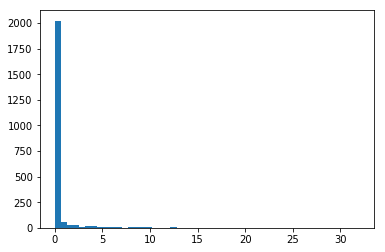

In [45]:
import matplotlib.pyplot as plt

plt.hist(np.sqrt(np.sum((centroids-centers)**2, axis=1)), bins=50)

In [ ]:
print(np.sqrt(np.sum((np.array(obj_center_label)-np.array(obj_centroids)[:,:3])**2, axis=1)))
print(np.sqrt(np.sum((np.array(obj_center_label)-np.array(obj_centroids)[:,:3])**2, axis=1)))
print(np.mean(np.sqrt(np.sum((np.array(obj_center_label)-np.array(obj_centroids)[:,:3])**2, axis=1))))
plt.hist(np.sqrt(np.sum((np.array(obj_center_label)-np.array(obj_centroids)[:,:3])**2, axis=1)), bins=100)